In [1]:
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers.legacy import Adam
import matplotlib.pyplot as plt
import cv2
from util import load_data, preprocess_data
from unet import unet

In [2]:
# Get the list of all available physical devices
physical_devices = tf.config.list_physical_devices('GPU')

# Count the number of GPUs
num_gpus = len(physical_devices)

print("Number of available GPUs:", num_gpus)

Number of available GPUs: 1


In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
print('GPU is available' if len(physical_devices) > 0 else 'Not available')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

GPU is available


In [4]:
# initialize input size and shape
INPUT_SIZE = (256, 256)
INPUT_SHAPE = (256, 256, 3) # color images, 3 channels

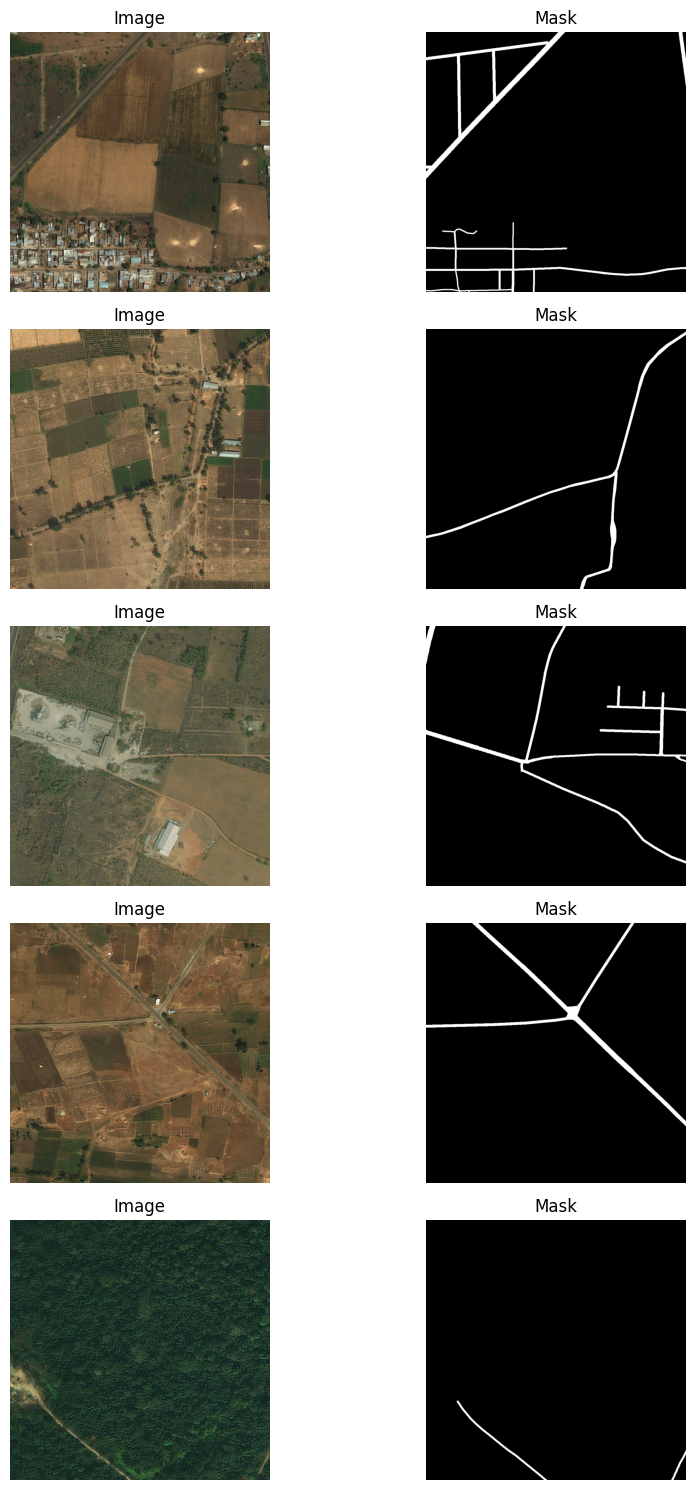

In [5]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import random

def display_data(dir_path, image_paths, mask_paths):

    fig, axes = plt.subplots(5, 2, figsize=(10, 15))

    # Iterate over the image and mask pairs and display them in subplots
    for i, (image_path, mask_path) in enumerate(zip(image_paths, mask_paths)):
        # Load the image and mask using your preferred method
        image = plt.imread(dir_path + image_path)
        mask = plt.imread(dir_path + mask_path)

        # Plot the image and mask in the corresponding subplot
        axes[i, 0].imshow(image)
        axes[i, 0].set_title('Image')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(mask)
        axes[i, 1].set_title('Mask')
        axes[i, 1].axis('off')

    # Adjust the spacing between subplots
    plt.tight_layout()
    plt.savefig('samples.png', bbox_inches='tight')  # Save as PNG image

    # Show the plot
    plt.show()
    return

# load data
dir_path = 'datasets/'
image_filenames, mask_filenames = load_data(dir_path)

# display the first 5 pairs of image and mask
random_indices = random.sample(range(0, len(image_filenames)), 5)
display_data(dir_path, image_filenames[random_indices], mask_filenames[random_indices])


In [6]:
# preprocess data
with tf.device("/device:GPU:0"):
    # no augmentation due to limited computational resources
    # already have a large amount of data, roughly 12,000 images and masks
    images, masks = preprocess_data(dir_path, image_filenames, mask_filenames, input_size=INPUT_SIZE, augmented=False) 


In [7]:
# get shape
print('Shape of image data: ' + str(images.shape))
print('Shape of mask data: ' + str(masks.shape))

Shape of image data: (1083, 256, 256, 3)
Shape of mask data: (1083, 256, 256, 1)


In [8]:
# Split the dataset into training and validation sets
train_images, val_images, train_masks, val_masks = train_test_split(images, masks, test_size=0.2, random_state=42)
train_images, test_images, train_masks, test_masks = train_test_split(train_images, train_masks, test_size=0.2, random_state=42)

In [9]:
# save check point
checkpoint = tf.keras.callbacks.ModelCheckpoint('models/save_best.h5', verbose=1, save_best_only=True)

<b>Given that we are predicting a binary mask, the output layer will be designed to accommodate this by having a size of 1.</b>

In [10]:
# Initialize the model
model = unet(INPUT_SHAPE, output_layer=1)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [11]:
# complie the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])


In [19]:
epochs = 20
with tf.device("/GPU:0"):
    history = model.fit(train_images, train_masks, batch_size=16, epochs=epochs, validation_data=(val_images, val_masks), callbacks=[checkpoint])


Epoch 1/20
44/44 [==============================] - ETA: 0s - loss: 0.0761 - accuracy: 0.9735
Epoch 1: val_loss improved from 0.09590 to 0.09061, saving model to models\save_best.h5
44/44 [==============================] - 41s 905ms/step - loss: 0.0761 - accuracy: 0.9735 - val_loss: 0.0906 - val_accuracy: 0.9701
Epoch 2/20
44/44 [==============================] - ETA: 0s - loss: 0.0730 - accuracy: 0.9743
Epoch 2: val_loss did not improve from 0.09061
44/44 [==============================] - 36s 826ms/step - loss: 0.0730 - accuracy: 0.9743 - val_loss: 0.0911 - val_accuracy: 0.9679
Epoch 3/20
44/44 [==============================] - ETA: 0s - loss: 0.0711 - accuracy: 0.9748
Epoch 3: val_loss improved from 0.09061 to 0.09019, saving model to models\save_best.h5
44/44 [==============================] - 39s 898ms/step - loss: 0.0711 - accuracy: 0.9748 - val_loss: 0.0902 - val_accuracy: 0.9702
Epoch 4/20
44/44 [==============================] - ETA: 0s - loss: 0.0693 - accuracy: 0.9752
Epoch

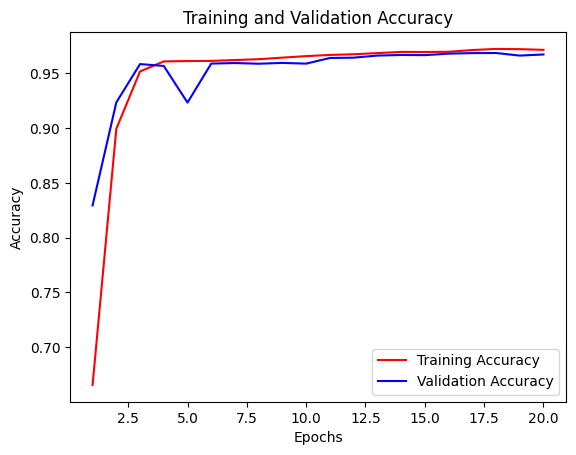

In [13]:
# Accessing training and testing accuracy
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

epochs = range(1, epochs + 1)

# Plotting
plt.plot(epochs, train_accuracy, 'r', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [20]:
model.save('models/.h5')

In [21]:
eval = model.evaluate(test_images, test_masks)
print('Test accuracy: ' + "{:.2f}".format(eval[1]))

6/6 [==============================] - 2s 337ms/step - loss: 0.0910 - accuracy: 0.9716
Test accuracy: 0.97


In [22]:
from tensorflow.keras.models import load_model
# load the saved model due to prior interuption
model = load_model('models/lasst.h5')

1/1 [==============================] - 1s 802ms/step


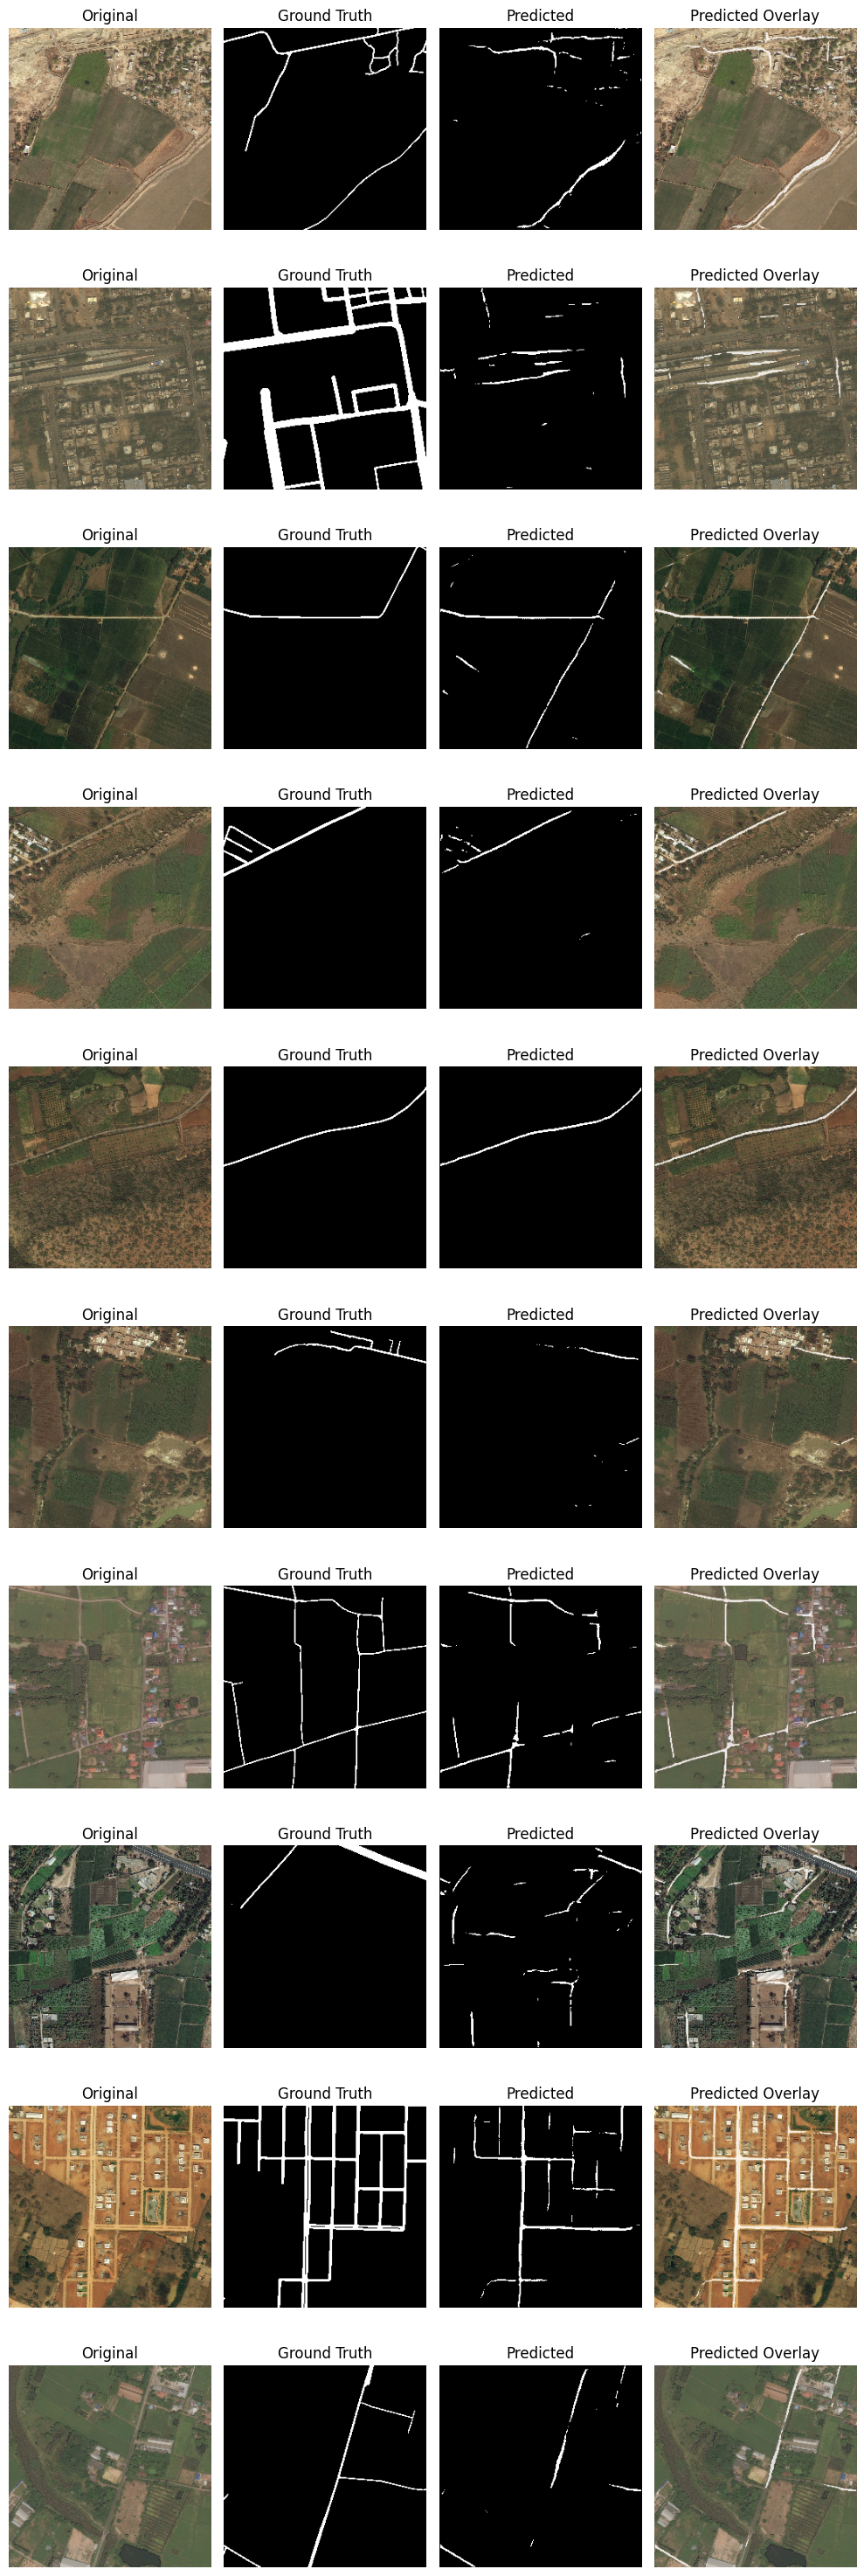

In [23]:
# display 10 random predictions
random_indices = random.sample(range(0, len(test_images)), 10)
test_sample = test_images[random_indices]

predictions = model.predict(test_sample)
predictions = (predictions > 0.5).astype(np.uint8)

fig, axes = plt.subplots(10, 4, figsize=(10, 3*10))

# Iterate over the image and mask pairs and display them in subplots
for i in range(len(test_sample)):

    image = (test_sample[i] * 255).astype(np.uint8)
    mask = predictions[i]
    ground_truth = test_masks[random_indices][i] * np.array([255, 255, 255]) # convert the forground into yellow color to achieve the desired aesthetic

    overlay = image.copy()

    mask = np.repeat(mask, 3, axis=2) # matching the size of the channel of the mask and the image to perform an overlay
    inverted_mask = 1 - mask

    yellow_mask = np.array([255, 255, 255]) * mask

    # Apply the mask on the image
    result = image * inverted_mask + yellow_mask
    alpha = 0.2
    predicted_overlay = cv2.addWeighted(overlay, alpha, result.astype(overlay.dtype), 1 - alpha, 0)

    # Plot the image and mask in the corresponding subplot
    axes[i, 0].imshow(image)
    axes[i, 0].set_title('Original')
    axes[i, 0].axis('off')
    
    axes[i, 1].imshow(ground_truth)
    axes[i, 1].set_title('Ground Truth')
    axes[i, 1].axis('off')
    
    axes[i, 2].imshow(yellow_mask)
    axes[i, 2].set_title('Predicted')
    axes[i, 2].axis('off')
    
    axes[i, 3].imshow(predicted_overlay)
    axes[i, 3].set_title('Predicted Overlay')
    axes[i, 3].axis('off')
    
# Adjust the spacing between subplots
plt.tight_layout()
plt.savefig('result.png', bbox_inches='tight')  # Save as PNG image

# Show the plot
plt.show()
# save the output



1/1 [==============================] - 0s 31ms/step


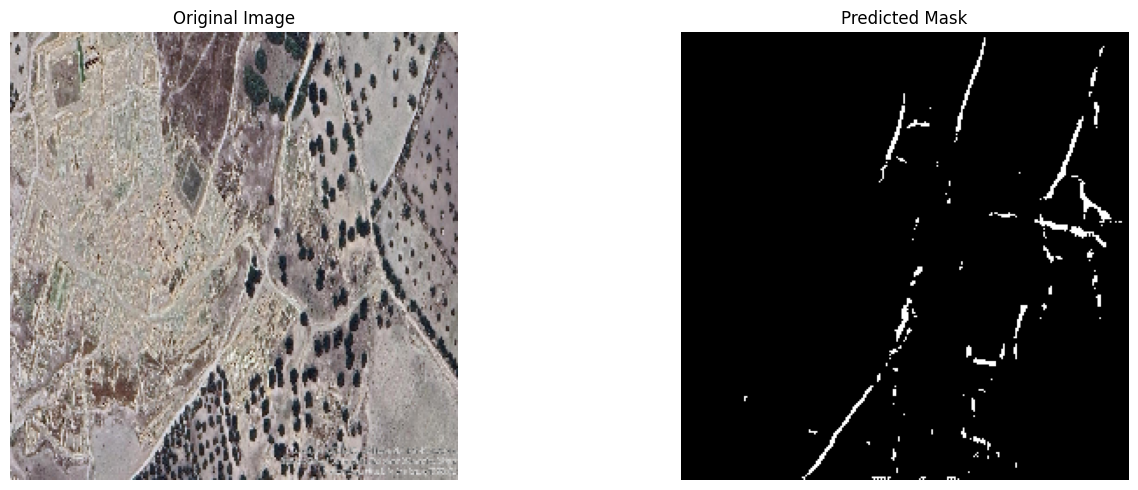

In [24]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
def load_and_preprocess_image(image_path, target_size=(256, 256)):
    """Load and preprocess the input image."""
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize to [0, 1]
    return img_array

def predict_image(model, image_path):
    """Predict the mask for the input image using the pre-trained model."""
    input_image = load_and_preprocess_image(image_path)
    prediction = model.predict(input_image)
    prediction = (prediction > 0.5).astype(np.uint8)  # Thresholding the prediction
    return input_image[0], prediction[0]

def visualize_results(image, mask, overlay_alpha=0.2):
    """Visualize the original image, predicted mask, and overlay."""
    image = (image * 255).astype(np.uint8)
    mask = np.repeat(mask, 3, axis=2) * np.array([255, 255, 255])  # Convert to white mask
    
    inverted_mask = 1 - mask
    result = image * inverted_mask + mask

    overlay = image.copy()
    predicted_overlay = cv2.addWeighted(overlay, overlay_alpha, result.astype(overlay.dtype), 1 - overlay_alpha, 0)

    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    axes[0].imshow(image)
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    axes[1].imshow(mask.astype(np.uint8))
    axes[1].set_title('Predicted Mask')
    axes[1].axis('off')


    plt.tight_layout()
    plt.show()

# Path to your own input image
input_image_path = 'Arch of Septimus Severus.jpg'

# Predict and visualize the results
original_image, predicted_mask = predict_image(model, input_image_path)
visualize_results(original_image, predicted_mask)